# STEP 3 Audio Preparation and Model


In [35]:
import os
import pandas as pd
import numpy as np
import librosa
import soundfile as sf
from tqdm.notebook import tqdm

In [2]:
#Global parameters
language_dic = {"es" : "Spanish" , "pt": "Portuguese", "it": "Italian", "fr": "French" }
analysis_window_length = 0.01  # 10 ms in seconds
language_mp3_path = "/language_detector/languages"

In [36]:
# number of repeats defined by minimum duration: ceil(10 seconds / min duration)
min_clip = 0.10115625
x_seconds = 5
num_reps = int(np.ceil(x_seconds / min_clip))
def repeat_audio_x_seconds(track, dur, num_repeats=10, fs=16000):
    num_samples_xs = int(fs * dur)
    track = np.concatenate([track]*num_repeats, axis=0)
    track = track[0:num_samples_xs]
    return track

In [44]:
def processing_audio(language_mp3_path, analysis_window_length, language_dic):
    """
    This function samples mp3 files, analyzes the dataset content, and builds a dictionary of features.
    """
    data = {"filename": [], "language": [], "mfccs": []}  # Initialize data dictionary here
   
    language_list = os.listdir(language_mp3_path)

    for language in language_list:
        language_path = os.path.join(language_mp3_path, language)

        if language not in language_dic:
            print(f"Skipping language {language} because it is not in language_dic")
            continue

        language_name = language_dic.get(language, "Unknown language!")

        clips_path = os.path.join(language_path, "clips")
        # Check if the clips directory exists
        if not os.path.isdir(clips_path):
            print(f"No 'clips' directory found in {language_path}")
            continue

        # get a list of all files in the folder
        mp3_list = os.listdir(clips_path)
        mp3_list = mp3_list[:15000]
       
        # looping through all mp3s in one language
        for mp3 in tqdm(mp3_list):
            # adding the filename as key
            data["filename"].append(mp3)
            # adding the label/language
            data["language"].append(language_name)
            # adding the clip
            audio_path = os.path.join(clips_path, mp3)
            audio_samples, fs = sf.read(audio_path)
            audio_samples = repeat_audio_x_seconds(audio_samples, x_seconds, num_repeats=num_reps, fs=fs)
            y = audio_samples
            sr = fs
            hop_length = int(analysis_window_length * sr)

            # Check if the length of audio_samples is greater than n_fft
            n_fft_value = 2048
            if len(y) < n_fft_value:
                print(f"Skipping {mp3} because its length is less than n_fft")
                continue

            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=128, hop_length=hop_length, n_fft=n_fft_value)
            mfccs_scaled_features = np.mean(mfcc.T,axis=0)
            data["mfccs"].append(mfccs_scaled_features)

    return data


In [45]:
data = processing_audio(language_mp3_path, analysis_window_length, language_dic)

  0%|          | 0/15000 [00:00<?, ?it/s]

Skipping language ja because it is not in language_dic


  0%|          | 0/15000 [00:00<?, ?it/s]

Skipping language ro because it is not in language_dic


  0%|          | 0/15000 [00:00<?, ?it/s]

Skipping language de because it is not in language_dic


  0%|          | 0/15000 [00:00<?, ?it/s]

Skipping language ca because it is not in language_dic


In [57]:
# Printing shape to confirm the input to the model 
df = pd.DataFrame(data)
print(df.head())
df.mfccs[50].shape

                       filename language  \
0  common_voice_it_20088702.mp3  Italian   
1  common_voice_it_19551854.mp3  Italian   
2  common_voice_it_18743170.mp3  Italian   
3  common_voice_it_17435298.mp3  Italian   
4  common_voice_it_17643038.mp3  Italian   

                                               mfccs  
0  [-509.47060362868444, 141.85304069517989, -21....  
1  [-462.48287206723944, 123.8630827591188, 5.182...  
2  [-555.0763167749433, 118.43354473531377, 15.84...  
3  [-375.62301620292976, 110.90526244896759, -22....  
4  [-357.23725544830376, 163.21737813118395, -27....  


(128,)

In [62]:
# Generate a boolean mask where True indicates the mfccs is not of size 128
mask = [item.shape == (128, 220500) for item in df['mfccs']]

# Apply the mask to the dataframe
non_conforming_rows = df[mask]

# Print rows where the size of the mfccs array is not 128
print(non_conforming_rows)

                           filename language  \
10693  common_voice_it_21431109.mp3  Italian   

                                                   mfccs  
10693  [[-1131.370849898476, -1131.370849898476, -113...  


In [63]:
mask = [item.shape != (128, 220500) for item in df['mfccs']]

# Filter the dataframe using the mask
df = df[mask]

In [64]:
#Check-point to see if all data was correctly loaded
print(f'The number of files loaded is: {len(df["filename"])}, in {df["language"].nunique()} languages')

The number of files loaded is: 59999, in 4 languages


In [65]:
X = np.array(df['mfccs'].tolist())
y=np.array(df['language'].tolist())

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [67]:
# using the train test split function
X_train, X_test, y_train, y_test = train_test_split(X,y ,
                                                    random_state=42,
                                                    train_size=0.8)

In [68]:
#Checking point
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(47999, 128) (12000, 128) (47999, 4) (12000, 4)


Model Creation

In [69]:
import tensorflow as tf
import visualkeras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [70]:
### No of classes
num_labels=y.shape[1]

In [71]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(128,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [72]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 100)               12900     
                                                                 
 activation_8 (Activation)   (None, 100)               0         
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_9 (Dense)             (None, 200)               20200     
                                                                 
 activation_9 (Activation)   (None, 200)               0         
                                                                 
 dropout_7 (Dropout)         (None, 200)               0         
                                                                 
 dense_10 (Dense)            (None, 100)              

In [73]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [74]:
## Training model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5',
                               verbose=1, save_best_only=True)
start = datetime.now()

history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
1466/1500 [============================>.] - ETA: 0s - loss: 2.2557 - accuracy: 0.4455
Epoch 1: val_loss improved from inf to 0.61339, saving model to saved_models/audio_classification.hdf5
1500/1500 [==============================] - 3s 2ms/step - loss: 2.2219 - accuracy: 0.4495 - val_loss: 0.6134 - val_accuracy: 0.7028
Epoch 2/100
1477/1500 [============================>.] - ETA: 0s - loss: 0.6368 - accuracy: 0.6698
Epoch 2: val_loss improved from 0.61339 to 0.47341, saving model to saved_models/audio_classification.hdf5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6359 - accuracy: 0.6701 - val_loss: 0.4734 - val_accuracy: 0.7633
Epoch 3/100
1495/1500 [============================>.] - ETA: 0s - loss: 0.5387 - accuracy: 0.7130
Epoch 3: val_loss improved from 0.47341 to 0.44848, saving model to saved_models/audio_classification.hdf5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.5388 - accuracy: 0.7131 - val_loss: 0.4485 - val_accu

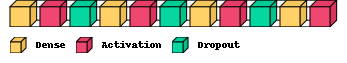

In [75]:
visualkeras.layered_view(model,legend=True, draw_volume=True)

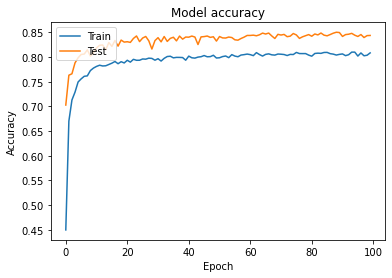

In [76]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

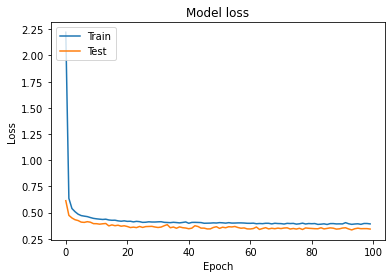

In [77]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

In [78]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.843916654586792


In [79]:
y_pred = model.predict(X_test)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)

375/375 [==============================] - 0s 729us/step


In [80]:
from sklearn.metrics import classification_report
target_names = sorted(df.language.unique())
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      French       0.71      0.80      0.75      3079
     Italian       0.76      0.66      0.70      2982
  Portuguese       0.96      0.96      0.96      2931
     Spanish       0.97      0.96      0.96      3008

    accuracy                           0.84     12000
   macro avg       0.85      0.84      0.84     12000
weighted avg       0.85      0.84      0.84     12000



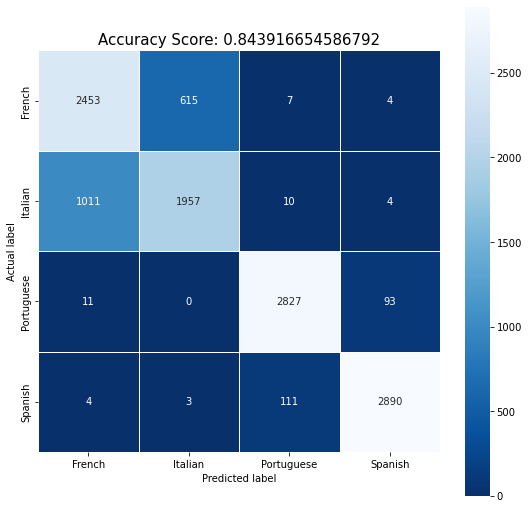

In [81]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Plotting the results:
plt.figure(figsize=(9,9))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r', xticklabels=target_names, yticklabels=target_names);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(test_accuracy[1])
plt.title(all_sample_title, size = 15);